In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import gc
from tqdm.notebook import tqdm
import collections

## 1. Read single vector text file and labels file from the extracted folder

In [2]:
path='../../Data/Extracted/'
train=pd.read_csv(path+'train_condensed_text.csv')
test=pd.read_csv(path+'test_condensed_text.csv')
labels=pd.read_csv(path+'labels.csv')

## 2. Calculate text statistics for each document (row)

In [3]:
def calculate(corpus):
    n_words=list(map(lambda val:len(val.split()),corpus))
    avg_word_len=list(map(lambda val:np.mean(list(map(lambda word:len(word),val.split()))),corpus))
    
    stat_dict={'n_words':n_words,
            'avg_word_len':avg_word_len}
    
    return stat_dict

In [4]:
train=calculate(train.values.ravel())
test=calculate(test.values.ravel())

## 2.1 Visualize calculated statistics

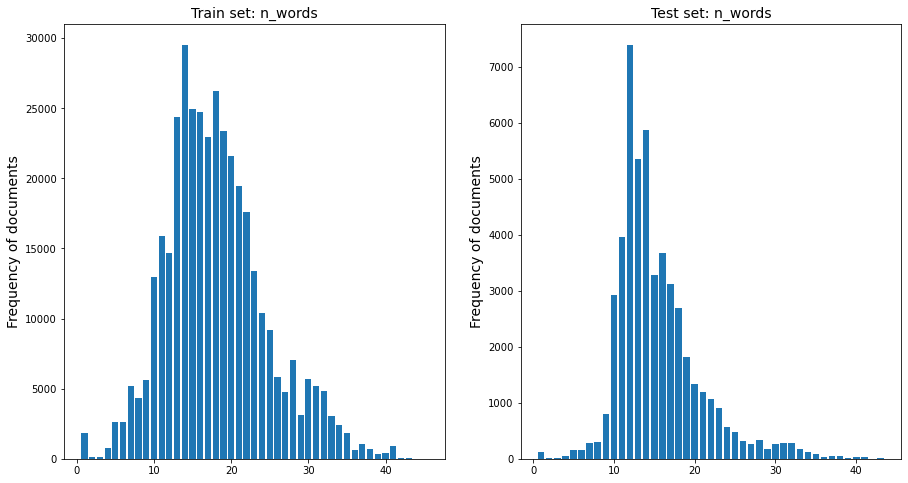

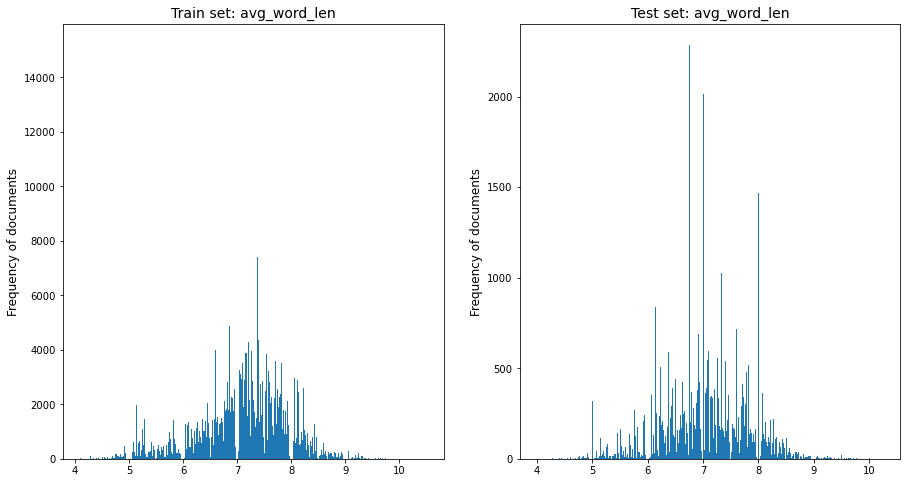

In [5]:
for feat in test.keys():
    if feat!='avg_word_len':
        fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,8))

        counter=collections.Counter(train[feat])
        ax[0].bar(counter.keys(),counter.values())
        ax[0].set_ylabel('Frequency of documents',fontsize=14)
        ax[0].set_title('Train set: '+feat,fontsize=14)

        counter=collections.Counter(test[feat])
        ax[1].bar(counter.keys(),counter.values())
        ax[1].set_ylabel('Frequency of documents',fontsize=14)
        ax[1].set_title('Test set: '+feat,fontsize=14);
        
    else:
        fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,8))

        ax[0].hist(train[feat],bins=500)
        ax[0].set_ylabel('Frequency of documents',fontsize=12)
        ax[0].set_title('Train set: '+feat,fontsize=14)

        ax[1].hist(test[feat],bins=500)
        ax[1].set_ylabel('Frequency of documents',fontsize=12)
        ax[1].set_title('Test set: '+feat,fontsize=14);

## 3. Calculate entropy of the features for all 9 labels into a data frame <br>
## 3.1 Prepare data frame for entropy calculation

In [6]:
train=pd.DataFrame(train)
test=pd.DataFrame(test)

In [7]:
# Digitize continuous variable (i.e., bucket values according to bins)
train['avg_word_len']=np.digitize(train['avg_word_len'].values,bins=[i/1 for i in range(4,9)])
test['avg_word_len']=np.digitize(test['avg_word_len'].values,bins=[i/1 for i in range(4,9)])

## 3.2 Calculate entropy of the labels grouped by each feature in the data frame

In [8]:
def find_closest_val(val,search_list):
    search_list=sorted(search_list)
    val=17
    delta=[(ind,abs((val-num))) for ind,num in enumerate(search_list)]
    delta=sorted(delta,key=lambda pair:pair[1])
    return search_list[delta[0][0]]

for feat in tqdm(train.columns):
    out_of_train=set(test[feat].unique())-set(train[feat].unique())
    if len(out_of_train)>0:
        replacement_pairs=[]
        for cat in out_of_train:
            replacement_val=find_closest_val(cat,list(train[feat].unique()))
            replacement_pairs.append((cat,replacement_val))

    for label in labels.columns:
        entropy={}
        for value in train[feat].unique():
            counts=labels[label][train[feat][train[feat]==value].index].value_counts()
            entropy[value]=scipy.stats.entropy(counts)
        train[label+'_'+feat]=train[feat].replace(entropy)
        test[label+'_'+feat]=test[feat].replace(entropy)    
        
        if len(out_of_train)>0:
            for pair in replacement_pairs:
                test[label+'_'+feat].replace({pair[0]:entropy[pair[1]]},inplace=True)
        
    del train[feat], test[feat]
gc.collect()

11741

## 4. Save entropy features data frames into extracted folder

In [9]:
path='../../Data/Extracted/'
train.to_csv(path+'train_feature_label_entropy.csv',index=False)
test.to_csv(path+'test_feature_label_entropy.csv',index=False)